Mingjia的酶挖掘——在钱老师的数据库中

第一步：对提供的数据集进行序列相似度比对，去除序列相似度高于80%的序列

In [2]:
pip install Bio

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 278 kB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 16.8 MB/s eta 0:00:01
     |████████████████████████████████| 64 kB 17.9 MB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install biopython==1.78

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 2.3 MB 1.4 MB/s eta 0:00:01
  Attempting uninstall: biopython
    Found existing installation: biopython 1.83
    Uninstalling biopython-1.83:
      Successfully uninstalled biopython-1.83
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bio 1.6.2 requires biopython>=1.80, but you have biopython 1.78 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [11]:
from Bio import SeqIO
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio.SubsMat import MatrixInfo as matlist

matrix = matlist.blosum62

def compute_sequence_similarity_percentage(seq1, seq2):
    # 使用局部序列对比算法计算相似性得分
    alignments = pairwise2.align.localxx(seq1, seq2)
    
    # 获取最佳比对
    best_alignment = alignments[0]
    aligned_seq1, aligned_seq2, score, begin, end = best_alignment
    
    # 计算匹配字符数
    matches = sum(a == b for a, b in zip(aligned_seq1, aligned_seq2))
    
    # 计算相似度百分比
    similarity_percentage = (matches / max(len(seq1), len(seq2))) * 100
    
    # 输出比对结果
    #print(format_alignment(*best_alignment))
    
    return similarity_percentage

def compare_sequences_in_fasta(file_path):
    # 读取FASTA文件中的序列
    sequences = list(SeqIO.parse(file_path, "fasta"))
    
    # 两两比对序列
    for i in range(len(sequences)):
        for j in range(i + 1, len(sequences)):
            seq1 = str(sequences[i].seq)
            seq2 = str(sequences[j].seq)
            similarity_percentage = compute_sequence_similarity_percentage(seq1, seq2)
            if similarity_percentage >= 80:
                print(f"Sequence {sequences[i].id} vs Sequence {sequences[j].id}: {similarity_percentage:.2f}%")

# 示例使用
file_path = "output.fasta"
compare_sequences_in_fasta(file_path)


Sequence WP_037930878.1 vs Sequence WP_044382979.1: 80.33%
Sequence WP_004000144.1 vs Sequence WP_043502029.1: 80.07%
Sequence WP_038576230.1 vs Sequence WP_053252429.1: 89.53%
Sequence XP_001827659.1 vs Sequence XP_022383494.1: 84.75%
Sequence XP_003047297.1 vs Sequence EXK23898.1: 87.21%
Sequence XP_006451305.1 vs Sequence XP_010113158.1: 80.74%
Sequence KDP33798.1 vs Sequence XP_010113158.1: 80.17%
Sequence KDP33798.1 vs Sequence XP_016682550.1: 80.58%
Sequence KFK29464.1 vs Sequence XP_009148011.1: 84.59%
Sequence KFK29464.1 vs Sequence XP_020872896.1: 87.50%
Sequence XP_009148011.1 vs Sequence XP_020872896.1: 89.82%
Sequence XP_010113158.1 vs Sequence XP_016682550.1: 80.74%
Sequence WP_038513254.1 vs Sequence WP_061987485.1: 90.03%
Sequence WP_038513254.1 vs Sequence WP_072027083.1: 92.83%
Sequence WP_061987485.1 vs Sequence WP_072027083.1: 88.74%
Sequence XP_033411594.1 vs Sequence GIC90259.1: 92.98%


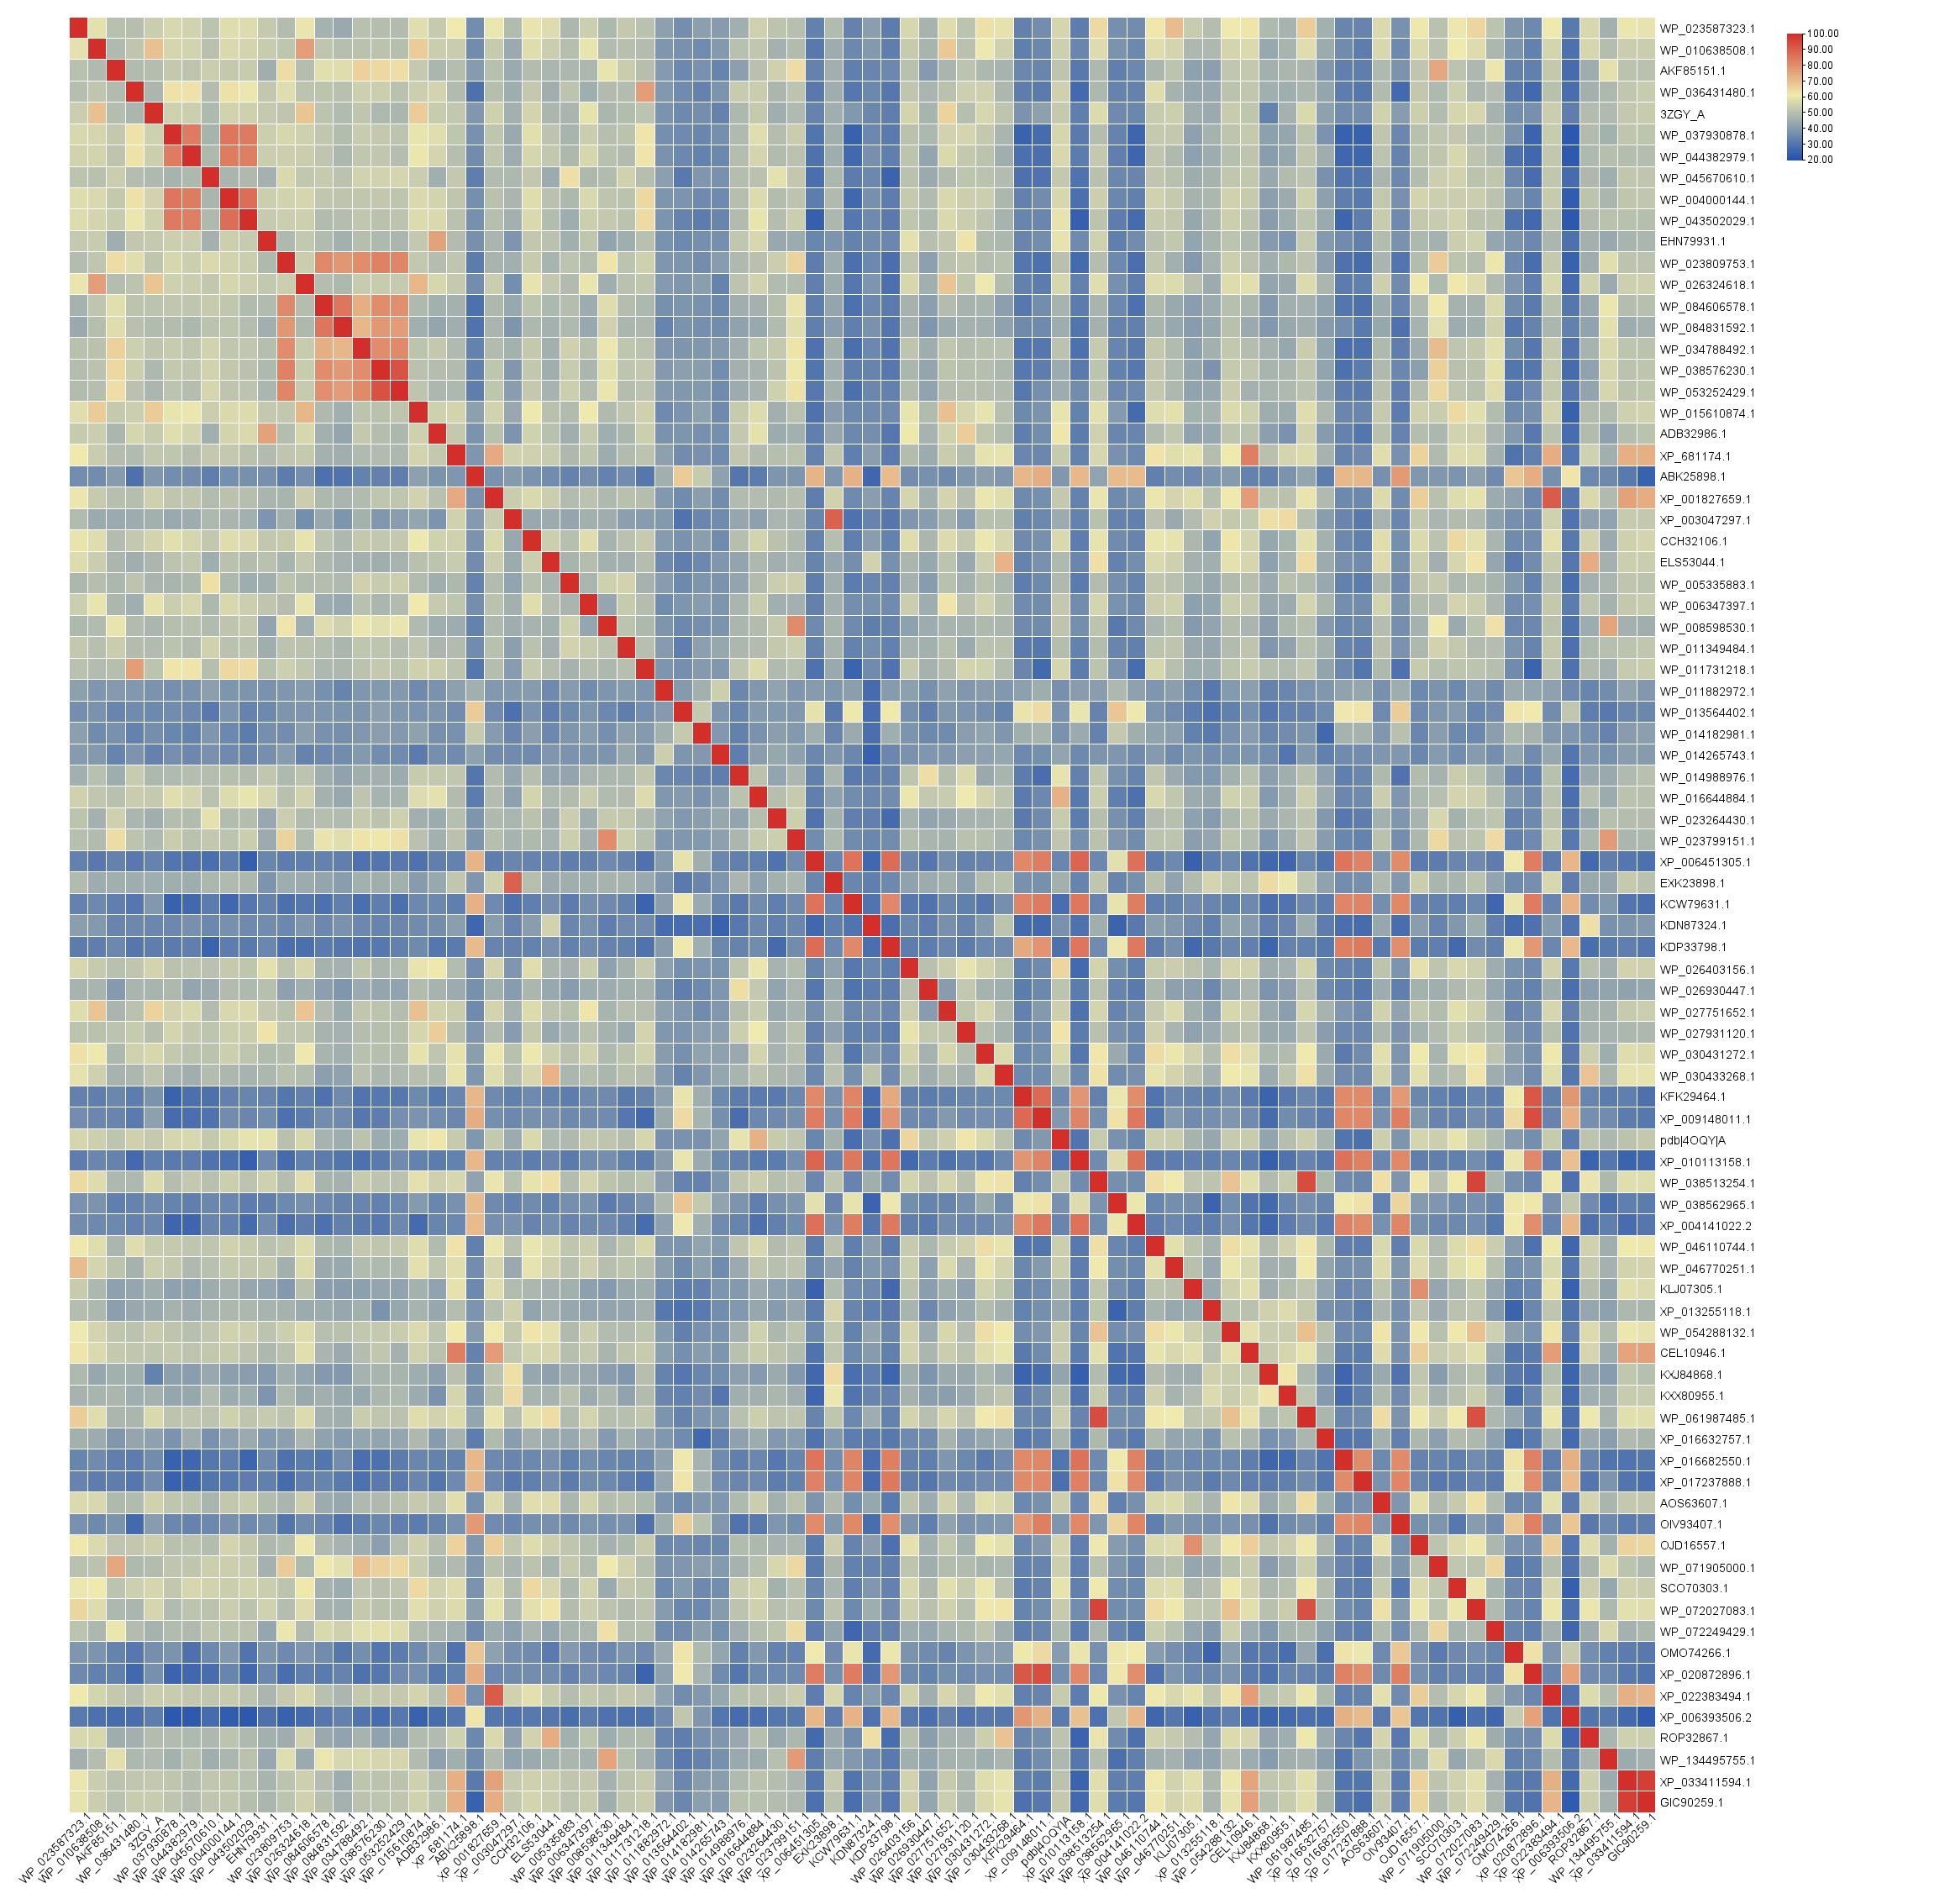

seqkit 是一个高效的命令行工具集，用于处理 FASTA 文件。你可以使用 seqkit grep 命令从 FASTA 文件中提取指定 ID 的序列。

In [12]:
conda install -c bioconda seqkit

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /root/miniconda3

  added / updated specs:
    - seqkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.7.2   |       h06a4308_0         127 KB  https://mirrors.tuna.tsinghua.edu.cn/anaconda/pkgs/main
    certifi-2024.7.4           |   py38h06a4308_0         158 KB  https://mirrors.tuna.tsinghua.edu.cn/anaconda/pkgs/main
    openssl-1.1.1w             |       h7f8727e_0         3.7 MB  https://mirrors.tuna.tsinghua.edu.cn/anaconda/pkgs/main
    seqkit-2.8.2               |       h9ee0642_1         7.1 MB  bioconda
    ------------------------------------------------------------
                                      

假设你的输入 FASTA 文件名为 input.fasta，目标 ID 文件名为 ids.txt（每行一个 ID），输出文件名为 output.fasta
提取指定序列

seqkit grep -f ids.txt output.fasta -o output_select.fasta

进化树构建：筛选完后的序列进行多序列比对建树，观察进化关系

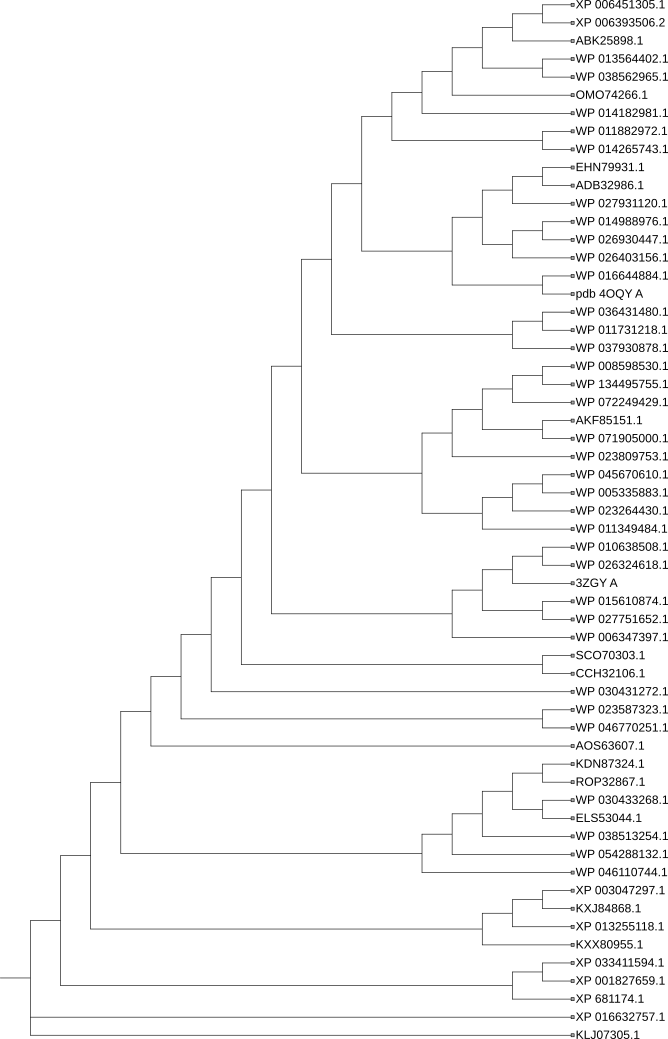

2.1 hmmbuild构建HMM文件 

该程序需要提供sto格式的序列比对文件，格式如图所示，它的主要区别就是# STOCKHOLM 1.0开头和//结尾。

一般我们要去获得已知基因组的某个家族成员，常用的方法就是从已知的某个物种的基因家族成员的保守结构序列去比对。而HMMER3.1需要sto格式的序列比对结果，因此我们要将比对之后的序列转换成sto格式。在线工具:sequence conversion可以将很多格式的比对结果转换成sto格式。需要注意的是：比对后的序列长度一定要一致，否则没有办法进行转换
hmmbuild globins4.hmm tutorial/globins4.sto


hmmbuild globins4.hmm tutorial/globins4.sto

hmmsearch mj.hmm deepseaclean.fasta --noali -E 1e-5 > mj.out

In [1]:
# 定义输入和输出文件路径
input_file = 'ids2.txt'
output_file = 'ids3.txt'

# 打开输入文件进行读取，并打开输出文件进行写入
with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
    # 遍历输入文件的每一行
    for line in infile:
        # 去除行中的空格
        cleaned_line = line.replace(' ', '')
        # 将去除空格后的行写入输出文件
        outfile.write(cleaned_line)

print("空格已经去除并保存到新文件中。")


空格已经去除并保存到新文件中。


seqkit grep -f ids3.txt deepseaclean.fasta -o output_select.fasta

基于TM-vec和PLMsearch的远同源蛋白挖掘

https://github.com/tymor22/tm-vec

https://github.com/maovshao/PLMSearch?tab=readme-ov-file

In [ ]:
挖掘出的蛋白和明佳给出的序列进行序列相似比对，发现19个酶与已知的蛋白序列相似度都很低，满足远同源特性

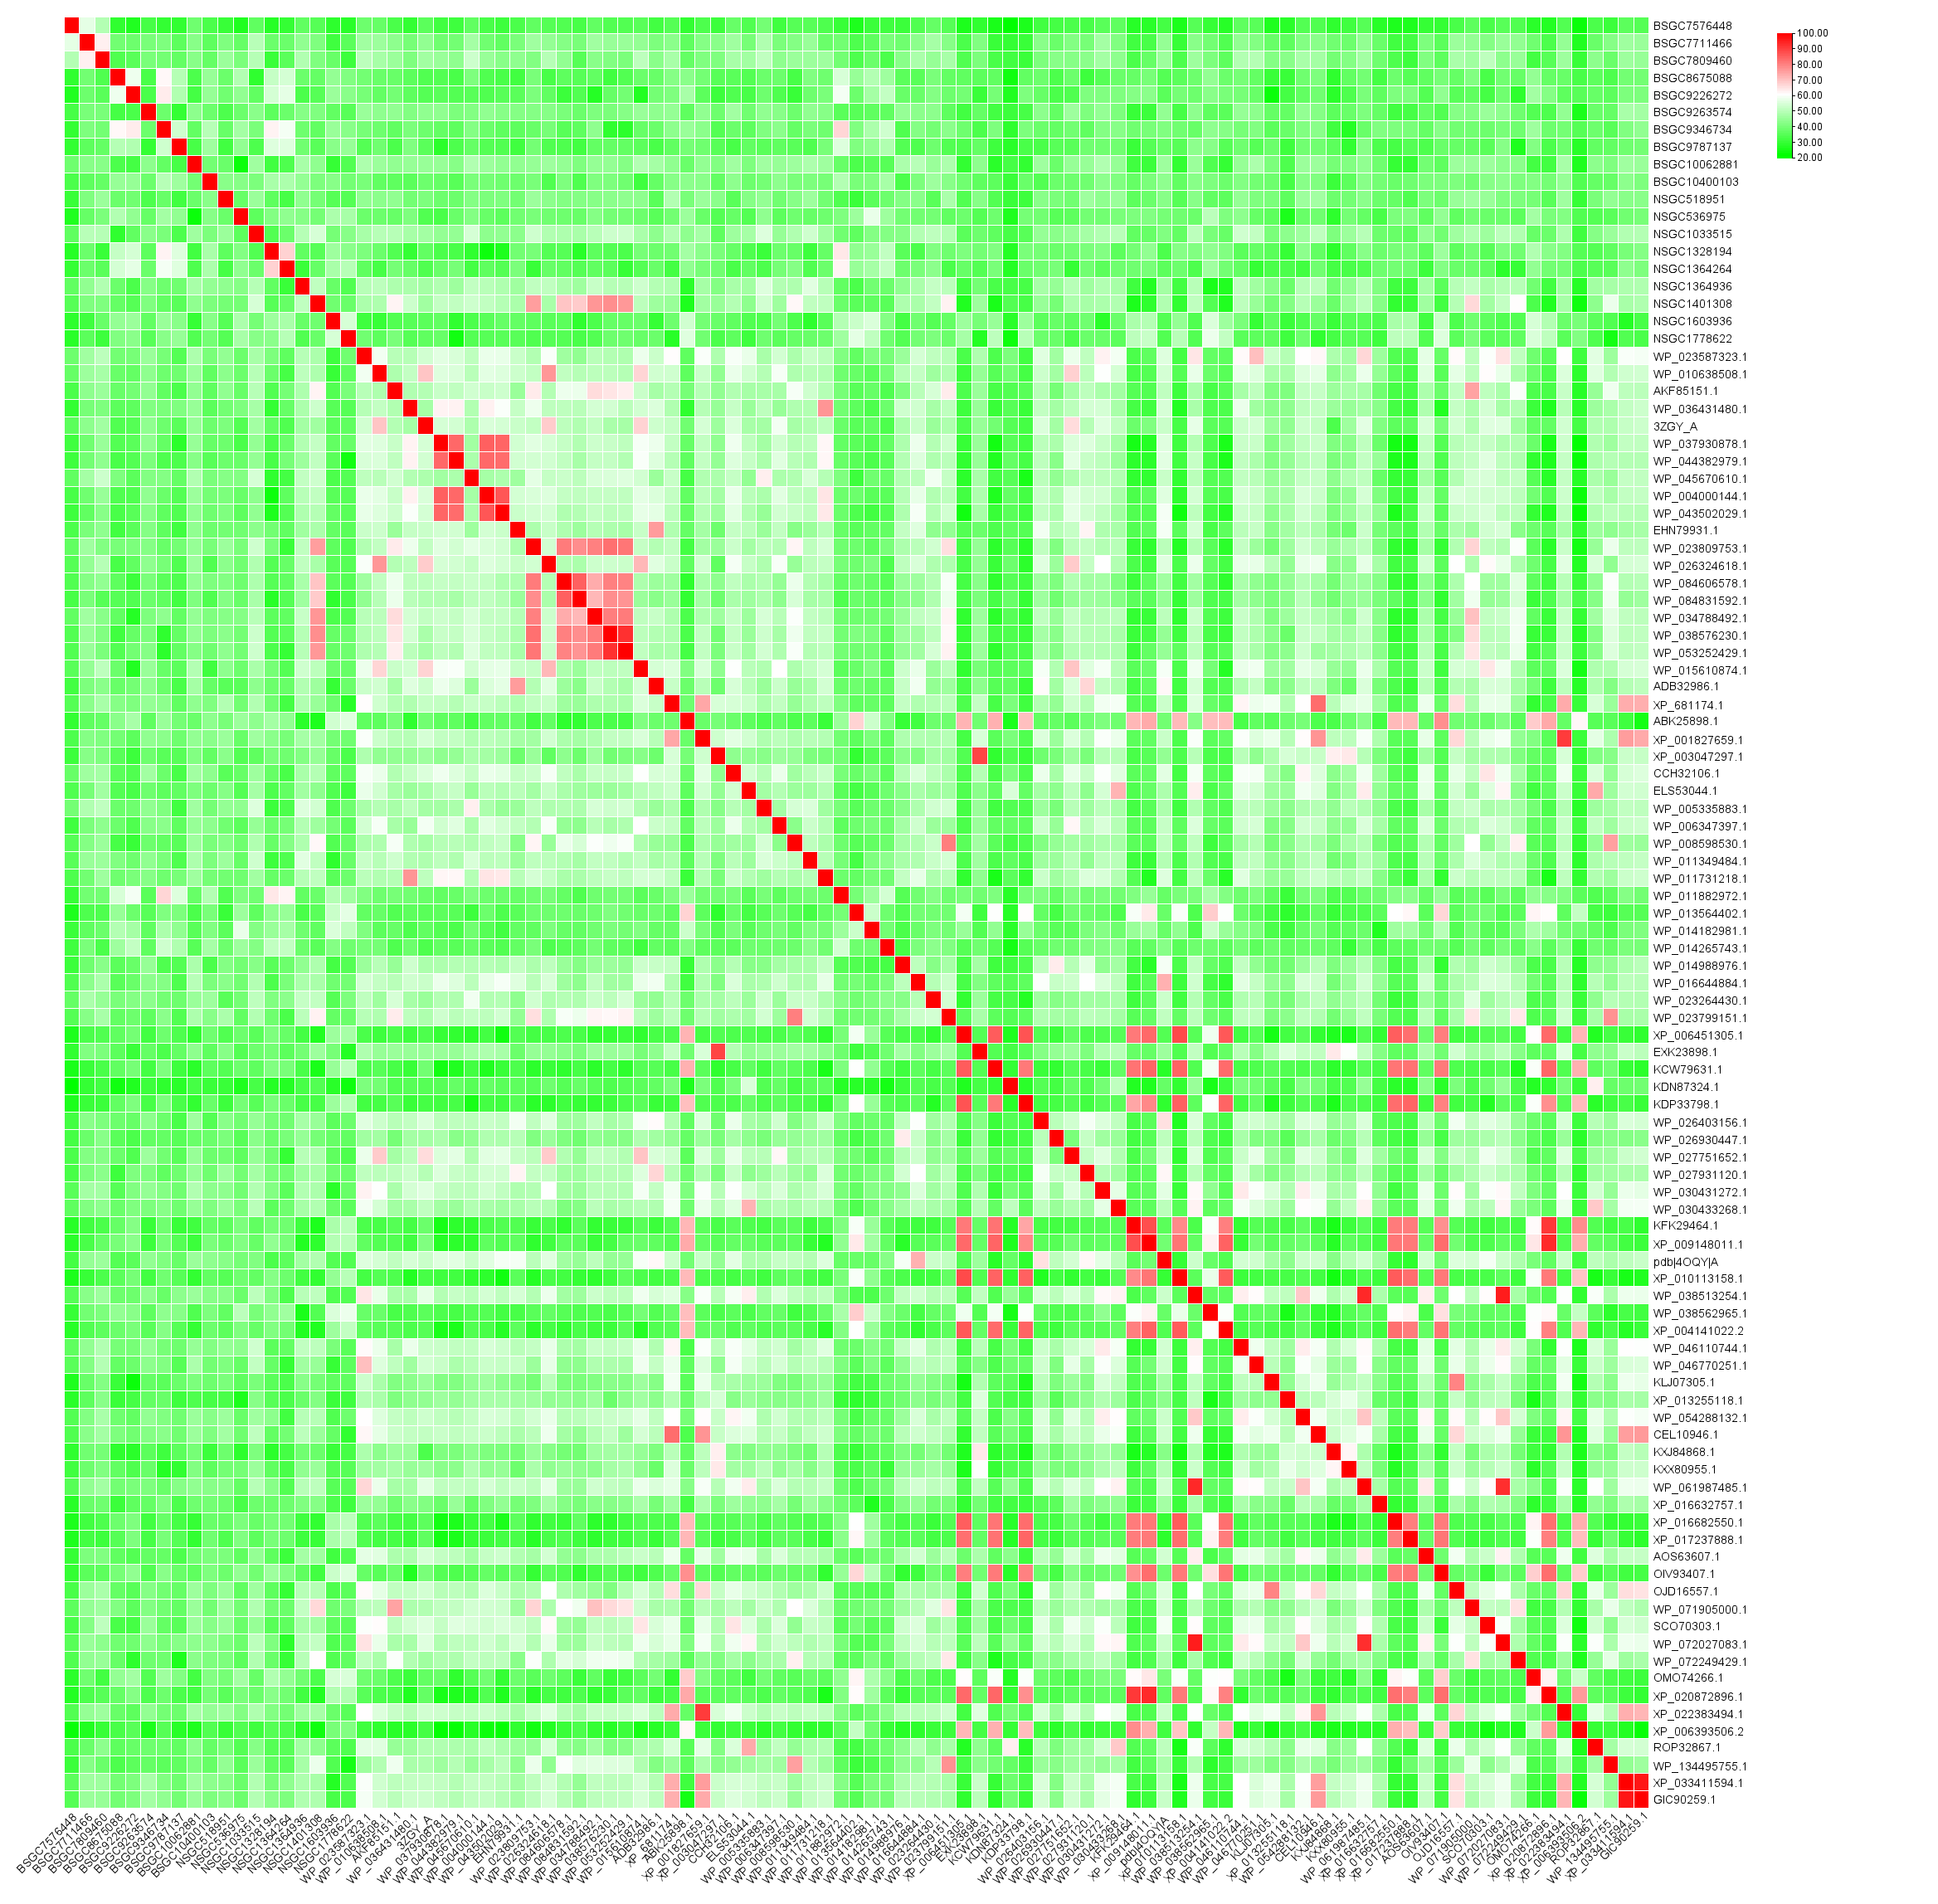